In [2]:
import gzip
from collections import defaultdict
import math
import scipy.optimize
import string
import random
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import pandas as pd
import numpy as np

In [3]:
def parse(path):
    """
    Reads the file line by line and uses eval() to parse
    Python-dictionary-style lines (single quotes, u'' strings).
    """
    g = gzip.open(path, 'rb')
    for l in g:
        # yield eval(l) handles both {'a':1} and {u'a':1}
        yield eval(l)

# print("Loading Bundle Data...")
# bundles = []
# for line in parse('/content/bundle_data.json.gz'):
#     bundles.append(line)
# df_bundles = pd.DataFrame(bundles)
# print(f"Successfully Loaded {len(df_bundles)} bundles.")


print("Loading Game Metadata...")
games_metadata = []
for line in parse('data/steam_games.json.gz'):
    if 'id' in line:
        games_metadata.append(line)
steam_games = pd.DataFrame(games_metadata)
print(f"Successfully Loaded {len(steam_games)} game metadata.")


# print("Loading User Reviews...")
# user_reviews = []
# count = 0
# for line in parse('/content/australian_user_reviews.json.gz'):
#     user_reviews.append(line)
#     count += 1
#     if count > 150000: break

# df_reviews = pd.DataFrame(user_reviews)
# # Flatten reviews (One row per review, not per user)
# review_data = []
# for idx, row in df_reviews.iterrows():
#     u_id = row['user_id']
#     for r in row['reviews']:
#         review_data.append({
#             'user_id': u_id,
#             'item_id': r['item_id'],
#             'recommend': r['recommend'],
#             'review_text': r['review']
#         })
# df_flat_reviews = pd.DataFrame(review_data)
# print(f"Loaded {len(df_flat_reviews)} individual reviews.")


print("Loading User Items (Ownership & Playtime)...")
# data_items = []
# limit = 150000  #Increase this if you have more RAM.
# count = 0

# for line in parse('/content/australian_users_items.json.gz'):
#     data_items.append(line)
#     count += 1
#     if count > limit:
#         break
# df_items = pd.DataFrame(data_items)
# print(f"Successfully Loaded {len(df_items)} users.")
data_items = []

# Loop over the generator yielded by parse() until it runs out of lines
for line in parse('data/australian_users_items.json.gz'):
    data_items.append(line)
    
australian_users_items = pd.DataFrame(data_items)
print(f"Successfully Loaded ALL {len(australian_users_items)} users.")

Loading Game Metadata...
Successfully Loaded 32133 game metadata.
Loading User Items (Ownership & Playtime)...
Successfully Loaded ALL 88310 users.


In [4]:
steam_games.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",0.83,http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,False,767400,彼岸领域,NaN,NaN
4,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"[Action, Indie, Casual, Sports]",1.79,http://steamcommunity.com/app/773570/reviews/?...,"[Single-player, Full controller support, HTC V...",2.99,False,773570,NaN,NaN,NaN


In [5]:
item_matrix = steam_games.copy()
item_matrix['tags'] = item_matrix['tags'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['specs'] = item_matrix['specs'].apply(lambda x: x if isinstance(x, list) else [])
item_matrix['title'] = item_matrix.apply(lambda x: x['title'] if isinstance(x['title'], str) else x['app_name'], axis=1)
def clean_price(x):
    if isinstance(x, float):
        return x
    if isinstance(x, str):
        x_lower = x.strip().lower()
        if 'free' in x_lower:
            return 0.0
        try:
            return float(x)
        except ValueError:
            return np.nan

    return np.nan
item_matrix['price'] = item_matrix['price'].apply(clean_price)
item_matrix['discount_price'] = item_matrix.apply(lambda x: x['discount_price'] if ((x['discount_price'] != np.nan) & (isinstance(x['discount_price'], str))) else x['price'], axis=1)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binary_matrix = mlb.fit_transform(item_matrix['tags'])
df_encoded = pd.DataFrame(binary_matrix, columns=mlb.classes_, index=item_matrix.index)
item_matrix = pd.concat([item_matrix[['id', 'title', 'price', 'discount_price', 'release_date', 'developer', 'sentiment', 'specs']], df_encoded], axis=1)

binary_matrix_2 = mlb.fit_transform(item_matrix['specs'])
df_encoded_2 = pd.DataFrame(binary_matrix_2, columns=mlb.classes_, index=item_matrix.index)
item_matrix = pd.concat([item_matrix, df_encoded_2], axis=1)

In [6]:
item_matrix

,id,title,price,discount_price,release_date,developer,sentiment,specs,1980s,1990's,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
0,761140,Lost Summoner Kitty,4.99,4.99,2018-01-04,Kotoshiro,NaN,[Single-player],0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,Ironbound,0.00,0.00,2018-01-04,Secret Level SRL,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,1,0,0,1,0,0,0,0,0,0
2,670290,Real Pool 3D - Poolians,0.00,0.00,2017-07-24,Poolians.com,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,弹炸人2222,0.99,0.99,2017-12-07,彼岸领域,NaN,[Single-player],0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,Log Challenge,2.99,2.99,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...",0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32128,773640,Colony On Mars,1.99,1.99,2018-01-04,"Nikita ""Ghost_RUS""",NaN,"[Single-player, Steam Achievements]",0,0,...,1,0,0,0,0,0,0,0,0,0
32129,733530,LOGistICAL: South Africa,4.99,4.99,2018-01-04,Sacada,NaN,"[Single-player, Steam Achievements, Steam Clou...",0,0,...,1,1,1,0,0,0,0,0,0,0
32130,610660,Russian Roads,1.99,1.99,2018-01-04,Laush Dmitriy Sergeevich,NaN,"[Single-player, Steam Achievements, Steam Trad...",0,0,...,1,0,0,1,0,0,0,0,0,0
32131,658870,EXIT 2 - Directions,4.99,4.99,2017-09-02,"xropi,stev3ns",1 user reviews,"[Single-player, Steam Achievements, Steam Cloud]",0,0,...,1,1,0,0,0,0,0,0,0,0


In [7]:
user_matrix = australian_users_items.explode('items').reset_index(drop=True)

items_normalized = pd.json_normalize(user_matrix['items'])

user_matrix = pd.concat([user_matrix.drop('items', axis=1), items_normalized], axis=1)

user_matrix = user_matrix[['steam_id','item_id','playtime_forever']]
user_matrix['y'] = pd.Series(user_matrix['playtime_forever'] >= 120.0).apply(int)
user_matrix# = user_matrix[['steam_id','item_id','y']]

,steam_id,item_id,playtime_forever,y
0,76561197970982479,10,6.0,0
1,76561197970982479,20,0.0,0
2,76561197970982479,30,7.0,0
3,76561197970982479,40,0.0,0
4,76561197970982479,50,0.0,0
...,...,...,...,...
5170010,76561198329548331,373330,0.0,0
5170011,76561198329548331,388490,3.0,0
5170012,76561198329548331,521570,4.0,0
5170013,76561198329548331,519140,3.0,0


In [8]:
user_matrix

,steam_id,item_id,playtime_forever,y
0,76561197970982479,10,6.0,0
1,76561197970982479,20,0.0,0
2,76561197970982479,30,7.0,0
3,76561197970982479,40,0.0,0
4,76561197970982479,50,0.0,0
...,...,...,...,...
5170010,76561198329548331,373330,0.0,0
5170011,76561198329548331,388490,3.0,0
5170012,76561198329548331,521570,4.0,0
5170013,76561198329548331,519140,3.0,0


In [11]:
user_matrix.groupby('item_id').count().sort_values(by='steam_id', ascending=False)

,steam_id,playtime_forever,y
item_id,,,
205790,49571,49571,49571
730,43776,43776,43776
4000,43301,43301,43301
304930,38682,38682,38682
223530,37044,37044,37044
...,...,...,...
515200,1,1,1
387130,1,1,1
395580,1,1,1


In [20]:
user_matrix['y'].value_counts()

y
1    3138006
0    1998300
Name: count, dtype: int64

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, f1_score

# --- 1. Fix the Threshold (Minutes vs Hours) ---
# Steam data is in minutes. 2 hours = 120 minutes.
# We modify your existing logic slightly:
print("Creating Target Label...")
user_matrix['y'] = (user_matrix['playtime_forever'] > 120).astype(int)

# --- 2. Filter Cold Start Users (Optional but Recommended) ---
# Remove users with fewer than 5 owned games to reduce noise
# user_counts = user_matrix['steam_id'].value_counts()
# valid_users = user_counts[user_counts >= 5].index
# user_matrix = user_matrix[user_matrix['steam_id'].isin(valid_users)]
# print(f"Dataset size after filtering cold-start users: {len(user_matrix)}")

# --- 3. Stratified Train/Test Split ---
# We want to randomly hide 20% of games for EACH user.
# A simple stratified split on 'steam_id' approximates this well enough for a baseline.

train_df, test_df = train_test_split(
    user_matrix,
    test_size=0.2,
    stratify=user_matrix['steam_id'], # Ensures every user is represented in both sets
    random_state=42
)

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")

Creating Target Label...


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_40073/4104757598.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_matrix['y'] = (user_matrix['playtime_forever'] > 120).astype(int)


Train size: 4109044
Test size: 1027262


In [43]:
# --- 4. Train the Baseline (Global Game Popularity) ---
# Logic: Calculate the probability that an owner plays the game > 2 hours.
# Group by Item ID -> Mean of 'y'
game_popularity = train_df.groupby('item_id')['y'].mean().to_dict()

# Calculate the global average (fallback for new games not seen in training)
global_avg_play_rate = train_df['y'].mean()

print(f"Global Average Play Rate: {global_avg_play_rate:.4f}")
# Example: If this is 0.30, it means 30% of owned games are played > 2 hours.

# --- 5. Predict on Test Set ---
def baseline_predict_proba(item_id):
    # Return the game's specific play rate, or the global average if unknown
    return game_popularity.get(item_id, global_avg_play_rate)

# Apply prediction
test_df['y_pred_proba'] = test_df['item_id'].apply(baseline_predict_proba)

# Convert probability to binary class (Threshold = 0.5)
# You can tweak the threshold (e.g., use the global_avg_play_rate as threshold)
test_df['y_pred_class'] = (test_df['y_pred_proba'] >= 0.5).astype(int)

# --- 6. Evaluation ---
print("\n--- Baseline Model Evaluation ---")
print("ROC-AUC Score:", roc_auc_score(test_df['y'], test_df['y_pred_proba']))
print("F1 Score (Target=1):", f1_score(test_df['y'], test_df['y_pred_class']))
print("\nClassification Report:")
print(classification_report(test_df['y'], test_df['y_pred_class']))

Global Average Play Rate: 0.3806

--- Baseline Model Evaluation ---
ROC-AUC Score: 0.8268542759829586
F1 Score (Target=1): 0.6610497998263043

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.82      0.80    637477
           1       0.68      0.64      0.66    389785

    accuracy                           0.75   1027262
   macro avg       0.74      0.73      0.73   1027262
weighted avg       0.75      0.75      0.75   1027262



In [21]:
print("Max playtime value:", user_matrix['playtime_forever'].max())

Max playtime value: 642773.0


In [22]:
user_matrix['playtime_forever'].describe()

count    5.136306e+06
mean     9.888204e+02
std      5.405387e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
Name: playtime_forever, dtype: float64

In [25]:
user_matrix.query('playtime_forever >= 10000')

,steam_id,item_id,playtime_forever,y
46,76561197970982479,1250,10006.0,1
104,76561197970982479,8930,10345.0,1
155,76561197970982479,35450,14194.0,1
178,76561197970982479,730,23532.0,1
465,76561198035864385,72850,13831.0,1
...,...,...,...,...
5167593,76561198284994428,304930,17586.0,1
5167654,76561198285507552,304930,14476.0,1
5167749,76561198293486792,730,29789.0,1
5169356,76561198304604920,304930,20201.0,1


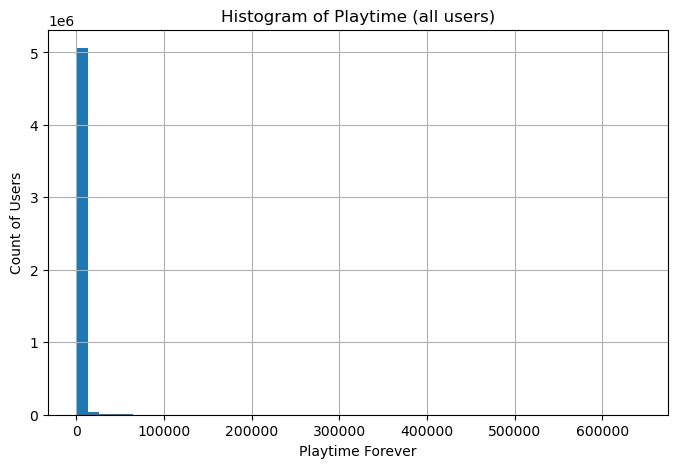

In [26]:
import matplotlib.pyplot as plt

# 1. Basic histogram of playtime_forever
plt.figure(figsize=(8, 5))
user_matrix['playtime_forever'].hist(bins=50)
plt.xlabel('Playtime Forever')
plt.ylabel('Count of Users')
plt.title('Histogram of Playtime (all users)')
plt.show()


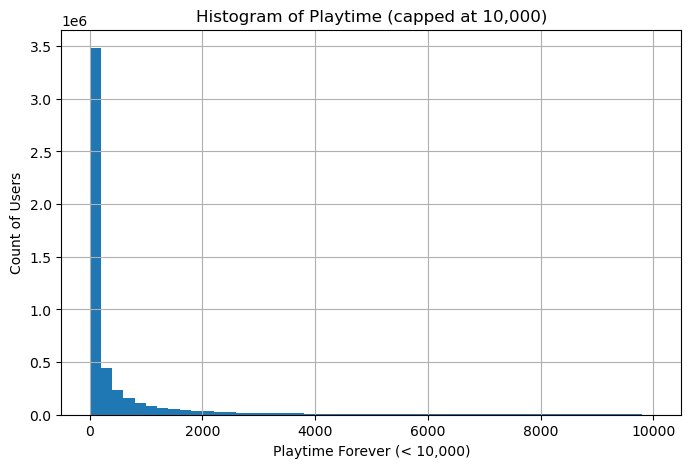

In [27]:
# 2. Exclude ultra-outliers for a clearer plot (e.g., keep only < 10,000)
subset = user_matrix.query('playtime_forever < 10000')

plt.figure(figsize=(8, 5))
subset['playtime_forever'].hist(bins=50)
plt.xlabel('Playtime Forever (< 10,000)')
plt.ylabel('Count of Users')
plt.title('Histogram of Playtime (capped at 10,000)')
plt.show()


In [28]:
heavy_users = user_matrix.query('playtime_forever >= 10000')
print(heavy_users.shape)       # how many?
print(heavy_users['playtime_forever'].describe())


(98362, 4)
count     98362.000000
mean      27780.912497
std       26871.532673
min       10000.000000
25%       13049.250000
50%       18534.000000
75%       31485.750000
max      642773.000000
Name: playtime_forever, dtype: float64


In [30]:
australian_users_items.query('playtime_forever == 64277')

UndefinedVariableError: name 'playtime_forever' is not defined

In [37]:
australian_users_items.query('steam_id == "76561197970687008"')

,user_id,items_count,steam_id,user_url,items
6008,wolop,107,76561197970687008,http://steamcommunity.com/id/wolop,"[{'item_id': '220', 'item_name': 'Half-Life 2'..."


In [47]:
print(australian_users_items.iloc[0])

user_id                                        76561197970982479
items_count                                                  277
steam_id                                       76561197970982479
user_url       http://steamcommunity.com/profiles/76561197970...
items          [{'item_id': '10', 'item_name': 'Counter-Strik...
Name: 0, dtype: object


In [38]:
australian_users_items.iloc[6008]

user_id                                                    wolop
items_count                                                  107
steam_id                                       76561197970687008
user_url                      http://steamcommunity.com/id/wolop
items          [{'item_id': '220', 'item_name': 'Half-Life 2'...
Name: 6008, dtype: object

In [39]:
australian_users_items.iloc[6008]['items']

[{'item_id': '220',
  'item_name': 'Half-Life 2',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '240',
  'item_name': 'Counter-Strike: Source',
  'playtime_forever': 41095,
  'playtime_2weeks': 0},
 {'item_id': '320',
  'item_name': 'Half-Life 2: Deathmatch',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '340',
  'item_name': 'Half-Life 2: Lost Coast',
  'playtime_forever': 14,
  'playtime_2weeks': 0},
 {'item_id': '360',
  'item_name': 'Half-Life Deathmatch: Source',
  'playtime_forever': 25,
  'playtime_2weeks': 0},
 {'item_id': '380',
  'item_name': 'Half-Life 2: Episode One',
  'playtime_forever': 0,
  'playtime_2weeks': 0},
 {'item_id': '2100',
  'item_name': 'Dark Messiah of Might & Magic Single Player',
  'playtime_forever': 16,
  'playtime_2weeks': 0},
 {'item_id': '2130',
  'item_name': 'Dark Messiah of Might & Magic Multi-Player',
  'playtime_forever': 23,
  'playtime_2weeks': 0},
 {'item_id': '4000',
  'item_name': "Garry's Mod",
  'playtime

In [ ]:
user_

In [41]:
user_matrix.query('steam_id == "76561197970687008"')

,steam_id,item_id,playtime_forever,y
588423,76561197970687008,220,0.0,0
588424,76561197970687008,240,41095.0,1
588425,76561197970687008,320,0.0,0
588426,76561197970687008,340,14.0,1
588427,76561197970687008,360,25.0,1
...,...,...,...,...
588525,76561197970687008,236110,1163.0,1
588526,76561197970687008,344040,0.0,0
588527,76561197970687008,349580,1.0,0
588528,76561197970687008,253030,0.0,0


In [46]:
item_matrix.head(10)

,id,title,price,discount_price,release_date,developer,sentiment,specs,1980s,1990's,...,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality
0,761140,Lost Summoner Kitty,4.99,4.99,2018-01-04,Kotoshiro,NaN,[Single-player],0,0,...,0,0,0,0,0,0,0,0,0,0
1,643980,Ironbound,0.00,0.00,2018-01-04,Secret Level SRL,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,1,0,0,1,0,0,0,0,0,0
2,670290,Real Pool 3D - Poolians,0.00,0.00,2017-07-24,Poolians.com,Mostly Positive,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,0,0,0,0,0,0,0,0,0,0
3,767400,弹炸人2222,0.99,0.99,2017-12-07,彼岸领域,NaN,[Single-player],0,0,...,0,0,0,0,0,0,0,0,0,0
4,773570,Log Challenge,2.99,2.99,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...",0,0,...,0,0,0,0,0,0,0,1,0,0
5,772540,Battle Royale Trainer,3.99,3.99,2018-01-04,Trickjump Games Ltd,Mixed,"[Single-player, Steam Achievements]",0,0,...,1,0,0,0,0,0,0,0,0,0
6,774276,SNOW - All Access Basic Pass,9.99,9.99,2018-01-04,Poppermost Productions,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,1,1,1,1,0,0,0,0,0,0
7,774277,SNOW - All Access Pro Pass,18.99,18.99,2018-01-04,Poppermost Productions,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,1,1,1,1,0,0,0,0,0,0
8,774278,SNOW - All Access Legend Pass,29.99,29.99,2018-01-04,Poppermost Productions,NaN,"[Single-player, Multi-player, Online Multi-Pla...",0,0,...,1,1,1,1,0,0,0,0,0,0
9,768800,Race,NaN,NaN,2018-01-04,RewindApp,NaN,"[Single-player, Multi-player, Partial Controll...",0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
print(item_matrix['sentiment'].value_counts())

sentiment
Mixed                      4103
Very Positive              3868
Positive                   3281
Mostly Positive            2744
1 user reviews             2496
2 user reviews             1756
3 user reviews             1231
4 user reviews              964
5 user reviews              846
Mostly Negative             802
6 user reviews              756
7 user reviews              619
8 user reviews              537
9 user reviews              488
Overwhelmingly Positive     302
Negative                    123
Very Negative                29
Overwhelmingly Negative       7
Name: count, dtype: int64


# Model Building

In [ ]:
# --- 1. Prepare Sentiment Mapping ---
# Define your exact mapping dictionary
sentiment_map = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Mostly Negative': -0.5,
    'Negative': -0.25,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

def get_sentiment_score(s):
    if not isinstance(s, str):
        return 0 # Default to neutral if missing
    
    # 1. Check strict mapping
    if s in sentiment_map:
        return sentiment_map[s]
    
    # 2. Check for "X user reviews" pattern (1-9 reviews)
    if 'user reviews' in s:
        return 0
        
    return 0 # Default fallback

# --- 2. Prepare Developer Logic ---
# Count games per developer in the FULL metadata (steam_games)
dev_counts = steam_games['developer'].value_counts()
# Create list of prolific developers (>= 50 games)
prolific_devs = set(dev_counts[dev_counts >= 50].index)

print(f"Found {len(prolific_devs)} developers with >= 50 games.")

# --- 3. Feature Engineering Function ---
def build_features(df_input, df_meta, train_set_reference):
    """
    df_input: The Train or Test split (User-Item interactions)
    df_meta: The steam_games dataframe
    train_set_reference: The Training dataframe (used for calculating popularity to avoid leakage)
    """
    # Merge interaction data with metadata
    # We need to ensure df_meta has 'id' renamed to 'item_id' matching df_input
    meta_clean = df_meta[['id', 'price', 'sentiment', 'developer', 'genres']].copy()
    meta_clean.rename(columns={'id': 'item_id'}, inplace=True)
    
    merged = df_input.merge(meta_clean, on='item_id', how='left')
    
    # Feature 1: Price (Fill NaN with 0)
    merged['price'] = merged['price'].fillna(0)
    
    # Feature 2: Ordinal Sentiment
    merged['sentiment_score'] = merged['sentiment'].apply(get_sentiment_score)
    
    # Feature 3: Prolific Developer (Binary)
    merged['is_prolific_dev'] = merged['developer'].apply(
        lambda x: 1 if x in prolific_devs else 0
    )
    
    # Feature 4: Global Popularity (Log Scaled)
    # We calculate popularity based on the TRAIN set only
    pop_counts = train_set_reference[train_set_reference['y'] == 1]['item_id'].value_counts()
    # Map the counts. If game not in train set, popularity is 0.
    merged['popularity'] = merged['item_id'].map(pop_counts).fillna(0)
    # Log transform to compress huge outliers (CS:GO vs Indie Game)
    merged['popularity_log'] = np.log1p(merged['popularity'])
    
    return merged[['price', 'sentiment_score', 'is_prolific_dev', 'popularity_log']]

# --- 4. Apply to Train and Test ---
print("Building Training Features...")
X_train = build_features(train_df, steam_games, train_df)
y_train = train_df['y']

print("Building Test Features...")
X_test = build_features(test_df, steam_games, train_df)
y_test = test_df['y']

print("\nFeature Engineering Complete!")
print("Features used: ['price', 'sentiment_score', 'is_prolific_dev', 'popularity_log']")
print(X_train.head())

In [ ]:
# --- 1. Prepare Item Metadata Features ---
# We take the item_matrix (which has genres, price) and clean it up for merging
item_features = item_matrix[['id', 'price', 'sentiment']].copy()
item_features.rename(columns={'id': 'item_id'}, inplace=True)

# Feature A: Encode "Sentiment" (Reviews) as a number
# (Positive = 1, Negative/Mixed = 0)
item_features['sentiment_score'] = item_features['sentiment'].apply(
    lambda x: 1 if isinstance(x, str) and 'positive' in x.lower() else 0
)
item_features.drop(columns=['sentiment'], inplace=True)

# Feature B: Global Popularity (Computed from Train set ONLY to avoid cheating)
# How many users in the training set played this game > 2 hours?
item_pop = train_df[train_df['y'] == 1].groupby('item_id').size()
item_features['global_popularity'] = item_features['item_id'].map(item_pop).fillna(0)

# Feature C: "Bundle Exposure" (The Grade 5 Feature)
# Logic: Does this game belong to a bundle? (Simple Boolean for speed)
# Uses the 'item_to_bundles' lookup we created earlier
item_features['is_bundled'] = item_features['item_id'].apply(
    lambda x: 1 if x in item_to_bundles else 0
)

# --- 2. Merge Features into Train and Test ---
print("Merging features into Training Set...")
train_feat = train_df.merge(item_features, on='item_id', how='left')

print("Merging features into Test Set...")
test_feat = test_df.merge(item_features, on='item_id', how='left')

# Fill missing values (e.g. if a game had no price data)
train_feat.fillna(0, inplace=True)
test_feat.fillna(0, inplace=True)

# Define our inputs (X) and target (y)
features_to_use = ['price', 'sentiment_score', 'global_popularity', 'is_bundled']
X_train = train_feat[features_to_use]
y_train = train_feat['y']
X_test = test_feat[features_to_use]
y_test = test_feat['y']

print("Feature Engineering Complete.")
print(f"Training with features: {features_to_use}")

# Test:

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
# STEP 0: RE-CREATE THE SPLIT (Missing Step)
# ==========================================
# We need to recreate the Target Label and Split the User Matrix
print("Re-creating Train/Test Split...")

# 1. Ensure Target Variable exists (Playtime > 2 hours/120 mins)
user_matrix['y'] = (user_matrix['playtime_forever'] > 120).astype(int)

# 2. Filter Cold Start Users (Optional: Keep users with >= 5 items)
user_counts = user_matrix['steam_id'].value_counts()
valid_users = user_counts[user_counts >= 5].index
user_matrix_filtered = user_matrix[user_matrix['steam_id'].isin(valid_users)]

# 3. Perform the Split
train_df, test_df = train_test_split(
    user_matrix_filtered,
    test_size=0.2,
    stratify=user_matrix_filtered['steam_id'],
    random_state=42
)
print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")

# ==========================================
# STEP 1: PRE-PROCESS RELEASE DATES
# ==========================================
print("Processing Release Dates...")

# Convert to datetime, turning errors (like "Coming Soon") into NaT (Not a Time)
steam_games['release_date_clean'] = pd.to_datetime(steam_games['release_date'], errors='coerce')

# Extract just the Year (Float format to handle NaNs)
steam_games['release_year'] = steam_games['release_date_clean'].dt.year

# Calculate the Median Year to fill missing values
median_year = steam_games['release_year'].median()
print(f"Median Release Year (for filling nulls): {median_year}")

# Fill NaNs with the median
steam_games['release_year'] = steam_games['release_year'].fillna(median_year)

# ==========================================
# STEP 2: SETUP YOUR CUSTOM FEATURES
# ==========================================

# Your Custom Sentiment Mapping
sentiment_map = {
    'Overwhelmingly Positive': 1,
    'Very Positive': 0.75,
    'Mostly Positive': 0.5,
    'Positive': 0.25,
    'Mixed': 0,
    'Mostly Negative': -0.5,
    'Negative': -0.25,
    'Very Negative': -0.75,
    'Overwhelmingly Negative': -1
}

def get_sentiment_score(s):
    if not isinstance(s, str): return 0 
    if s in sentiment_map: return sentiment_map[s]
    if 'user reviews' in s: return 0
    return 0

# Developer Logic
dev_counts = steam_games['developer'].value_counts()
prolific_devs = set(dev_counts[dev_counts >= 50].index)

# ==========================================
# STEP 3: BUILD FEATURES FUNCTION
# ==========================================
def build_features(df_input, df_meta, train_set_reference):
    # 1. Prepare Metadata
    # Include 'release_year' in the merge list
    meta_clean = df_meta[['id', 'price', 'sentiment', 'developer', 'release_year']].copy()
    meta_clean.rename(columns={'id': 'item_id'}, inplace=True)
    
    # 2. Merge
    merged = df_input.merge(meta_clean, on='item_id', how='left')
    
    # 3. Clean Missing Data after merge
    merged['price'] = merged['price'].fillna(0)
    merged['release_year'] = merged['release_year'].fillna(median_year) # Fallback if item missing from meta
    
    # --- Feature Creation ---
    
    # A. Sentiment Score
    merged['sentiment_score'] = merged['sentiment'].apply(get_sentiment_score)
    
    # B. Prolific Developer
    merged['is_prolific_dev'] = merged['developer'].apply(lambda x: 1 if x in prolific_devs else 0)
    
    # C. Game Age (Current Year - Release Year)
    # Using 2025 as "Current Year" so data stays relevant
    merged['game_age'] = 2025 - merged['release_year']
    
    # D. Global Popularity (Log)
    pop_counts = train_set_reference[train_set_reference['y'] == 1]['item_id'].value_counts()
    merged['popularity'] = merged['item_id'].map(pop_counts).fillna(0)
    merged['popularity_log'] = np.log1p(merged['popularity'])
    
    # Return specific columns
    return merged[['price', 'sentiment_score', 'is_prolific_dev', 'game_age', 'popularity_log']]

# ==========================================
# STEP 4: APPLY AND VERIFY
# ==========================================
print("Building Training Features...")
X_train = build_features(train_df, steam_games, train_df)
y_train = train_df['y']

print("Building Test Features...")
X_test = build_features(test_df, steam_games, train_df)
y_test = test_df['y']

print("\nFeature Engineering Complete!")
print(X_train.head())

Re-creating Train/Test Split...


/var/folders/9j/_8sx8kxj7cl3vnn7_kxmts1m0000gn/T/ipykernel_40073/1351515809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_matrix['y'] = (user_matrix['playtime_forever'] > 120).astype(int)


Train size: 4109044 | Test size: 1027262
Processing Release Dates...
Median Release Year (for filling nulls): 2016.0
Building Training Features...
Building Test Features...

Feature Engineering Complete!
   price  sentiment_score  is_prolific_dev  game_age  popularity_log
0      0             0.00                0       9.0        3.401197
1  14.99             0.75                0      12.0        6.612041
2   9.99             0.75                0      20.0        7.105786
3  19.99             0.75                0       9.0        7.394493
4   Free             0.75                0      14.0        8.676417
